# Relatório — RatatouilleOS (V1)

Este relatório conta a história de uma cozinha com 1 fogão e vários cozinheiros:
- Sem semáforo (controle), podem ocorrer colisões (dois pratos no fogão ao mesmo tempo)
- Com semáforo, há exclusão mútua e os resultados são corretos
- FCFS (ordem de chegada) vs SJF (pratos mais rápidos primeiro) mostram trade-offs clássicos

## Resumo executivo
- Semáforo é requisito de correção: sem ele, resultados parecem "bons" porém incorretos (colisões/overlaps)
- SJF reduz o tempo médio de espera, mas pode penalizar pratos longos (fairness)
- FCFS é simples e previsível; SJF otimiza médias

## Como ler os gráficos
- Barras: menor é melhor (espera e turnaround)
- Linha: utilização do fogão (0–1)
- Gantt: timeline dos pratos; vermelho indica sobreposição (erro) no modo sem semáforo



In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

OUTPUTS = Path("../outputs")
summary_path = OUTPUTS / "summaries.csv"
if not summary_path.exists():
    raise SystemExit("Gere os arquivos rodando: poetry run ratatouille")

df = pd.read_csv(summary_path)
# Nomes amigáveis para as variantes
name_map = {
    "A_FCFS_no_sem": "FCFS sem semáforo",
    "B_FCFS_sem": "FCFS com semáforo",
    "C_SJF_no_sem": "SJF sem semáforo",
    "D_SJF_sem": "SJF com semáforo",
}
df["variant_h"] = df["variant"].map(name_map)
df


,scenario,variant,avg_waiting_time,avg_turnaround_time,throughput,utilization,max_queue,collisions,variant_h
0,bursty,A_FCFS_no_sem,2.486920,5.539055,1.061700,1.817301,13,28,FCFS sem semáforo
1,bursty,B_FCFS_sem,1.236316,3.295979,1.466073,2.509460,29,0,FCFS com semáforo
2,bursty,C_SJF_no_sem,0.647366,3.369654,1.116222,1.910625,8,27,SJF sem semáforo
3,bursty,D_SJF_sem,0.121994,2.446338,1.299808,2.224867,27,0,SJF com semáforo
4,poisson,A_FCFS_no_sem,1.027088,3.933925,1.160698,1.524271,11,37,FCFS sem semáforo
5,poisson,B_FCFS_sem,0.304198,2.797370,1.152319,1.513268,32,0,FCFS com semáforo
6,poisson,C_SJF_no_sem,0.350736,3.058759,1.147988,1.507580,10,35,SJF sem semáforo
7,poisson,D_SJF_sem,0.027178,1.809949,1.152319,1.513268,25,0,SJF com semáforo
8,mix,A_FCFS_no_sem,10.852216,15.473680,1.065700,1.907123,28,36,FCFS sem semáforo
9,mix,B_FCFS_sem,2.610126,6.603133,1.429116,2.557473,35,0,FCFS com semáforo


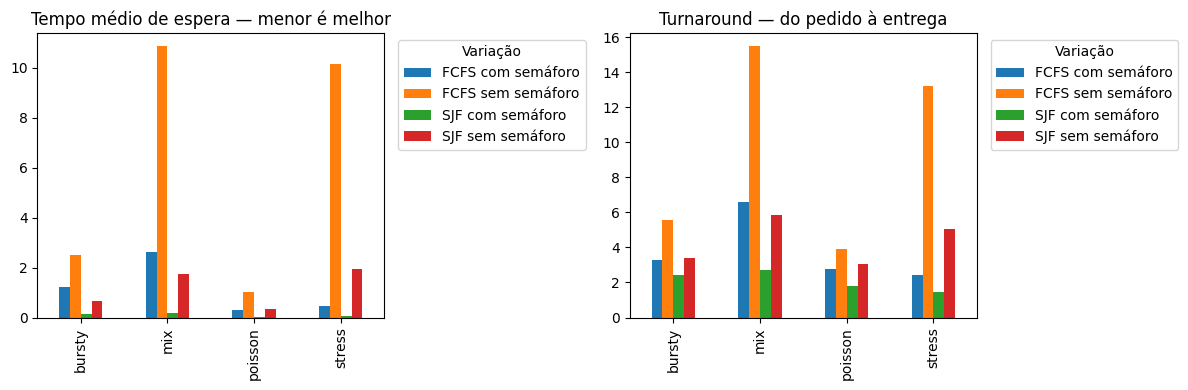

In [2]:
# Comparação por cenário (médias)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
wait = df.pivot(index="scenario", columns="variant_h", values="avg_waiting_time")
turn = df.pivot(index="scenario", columns="variant_h", values="avg_turnaround_time")
wait.plot(kind="bar", ax=axes[0], title="Tempo médio de espera — menor é melhor")
turn.plot(kind="bar", ax=axes[1], title="Turnaround — do pedido à entrega")
for ax in axes:
    ax.set_xlabel("")
    ax.legend(title="Variação", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [3]:
# Percentil 90 (p90) — mostra cauda longa
p90 = df.groupby(["scenario", "variant_h"])[["avg_waiting_time", "avg_turnaround_time"]].quantile(0.90)
p90.unstack(level=1)


avg_waiting_time                                     \
variant_h FCFS com semáforo FCFS sem semáforo SJF com semáforo   
scenario                                                         
bursty             1.236316          2.486920         0.121994   
mix                2.610126         10.852216         0.181171   
poisson            0.304198          1.027088         0.027178   
stress             0.445879         10.141051         0.042281   

                           avg_turnaround_time                    \
variant_h SJF sem semáforo   FCFS com semáforo FCFS sem semáforo   
scenario                                                           
bursty            0.647366            3.295979          5.539055   
mix               1.749886            6.603133         15.473680   
poisson           0.350736            2.797370          3.933925   
stress            1.927038            2.414817         13.221733   

                                             
variant_h SJF com semáforo SJF sem semáforo  
scenario                                     
bursty            2.446338         3.369654  
mix               2.740041         5.869613  
poisson           1.809949         3.058759  
stress            1.453107         5.031844

In [4]:
# Tabela-resumo por cenário (média, utilização, colisões)
cols = [
    "scenario", "variant_h", "avg_waiting_time", "avg_turnaround_time", "utilization", "collisions"
]
summary_view = df[cols].sort_values(["scenario", "variant_h"]).reset_index(drop=True)
summary_view


,scenario,variant_h,avg_waiting_time,avg_turnaround_time,utilization,collisions
0,bursty,FCFS com semáforo,1.236316,3.295979,2.509460,0
1,bursty,FCFS sem semáforo,2.486920,5.539055,1.817301,28
2,bursty,SJF com semáforo,0.121994,2.446338,2.224867,0
3,bursty,SJF sem semáforo,0.647366,3.369654,1.910625,27
4,mix,FCFS com semáforo,2.610126,6.603133,2.557473,0
5,mix,FCFS sem semáforo,10.852216,15.473680,1.907123,36
6,mix,SJF com semáforo,0.181171,2.740041,2.523213,0
7,mix,SJF sem semáforo,1.749886,5.869613,2.208081,36
8,poisson,FCFS com semáforo,0.304198,2.797370,1.513268,0
9,poisson,FCFS sem semáforo,1.027088,3.933925,1.524271,37


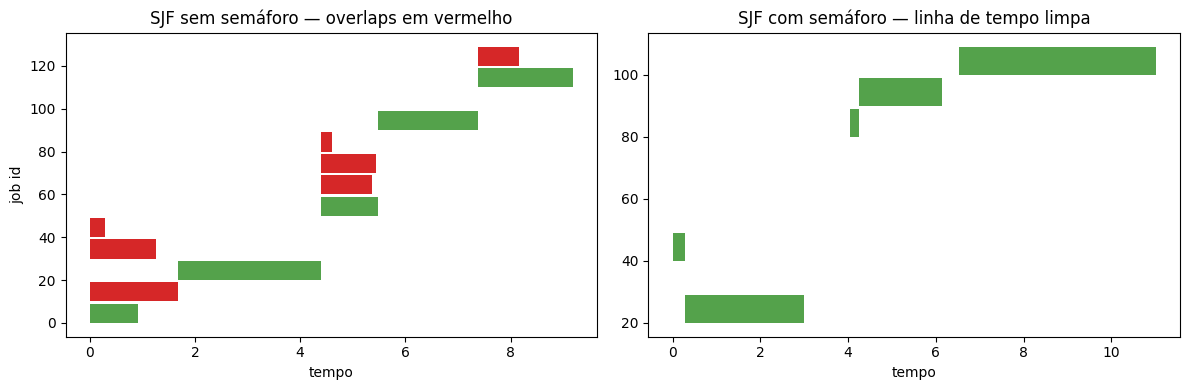

In [5]:
# Gantt lado a lado (bursty): semáforo vs sem semáforo
import pandas as pd
from IPython.display import display

jobs_sem = pd.read_csv(OUTPUTS / "bursty_D_SJF_sem_jobs.csv")
jobs_no = pd.read_csv(OUTPUTS / "bursty_C_SJF_no_sem_jobs.csv")

# Marcar sobreposições simples no modo sem semáforo
jobs_no = jobs_no.sort_values("start_time").reset_index(drop=True)
overlaps = []
current_finish = -1.0
for _, row in jobs_no.iterrows():
    overlaps.append(1 if row["start_time"] < current_finish else 0)
    current_finish = max(current_finish, row["finish_time"])
jobs_no["overlap"] = overlaps

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for _, row in jobs_no.head(12).iterrows():
    color = "#D62728" if row["overlap"] == 1 else "#54A24B"
    axes[0].broken_barh([(row["start_time"], row["cook_time"])], (row["id"]*10, 9), facecolors=color)
axes[0].set_title("SJF sem semáforo — overlaps em vermelho")
axes[0].set_xlabel("tempo")
axes[0].set_ylabel("job id")

for _, row in jobs_sem.head(12).iterrows():
    axes[1].broken_barh([(row["start_time"], row["cook_time"])], (row["id"]*10, 9), facecolors="#54A24B")
axes[1].set_title("SJF com semáforo — linha de tempo limpa")
axes[1].set_xlabel("tempo")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


## O que aprendemos?
- Semáforo garante correção: sem overlaps, métricas confiáveis
- SJF tende a reduzir espera/turnaround em média
- FCFS é previsível; SJF pode punir pratos longos — discutir fairness

## Apêndice técnico (resumo)
- 1 fogão (seção crítica), N cozinheiros (threads)
- FCFS vs SJF não-preemptivo
- Métricas: espera, turnaround, utilização, colisões

